In [2]:
import math
import collections
from matplotlib import pyplot as plt
from random import *
from collections import Counter, defaultdict
from probability import inverse_normal_cdf
from linear_algebra import shape, get_row, get_column, make_matrix, \
    vector_mean, vector_sum, dot, magnitude, vector_subtract, scalar_multiply
from gradient_descent import maximize_batch
from stats import correlation, standard_deviation, mean
import dateutil.parser
from functools import partial, reduce

In [3]:
def bucketize(point,bucket_size):
    return bucket_size * math.floor(point/bucket_size)

In [4]:
def make_histogram(points,bucket_size):
    return collections.Counter(bucketize(point,bucket_size) for point in points)

In [5]:
def plot_histogram(points,buckect_size,title = ""):
    histogram = make_histogram(points,buckect_size)
    plt.bar(histogram.keys(),histogram.values(),width=buckect_size)
    plt.title(title)
    plt.show()


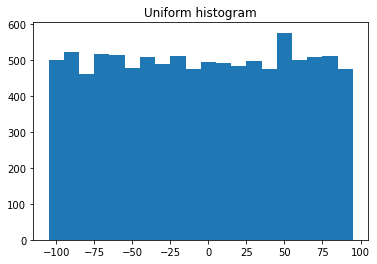

In [6]:


uniform = [200 * random() - 100 for _ in range(10000)]

normal = [57 * inverse_normal_cdf(random()) for _ in range(100000)]



plot_histogram(uniform,10,"Uniform histogram")

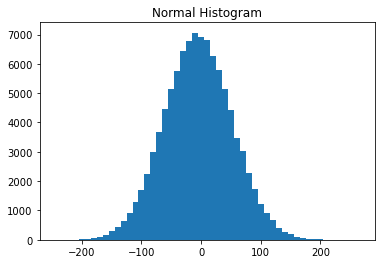

In [7]:
plot_histogram(normal,10 , "Normal Histogram")

Ahora vamos a trbajar con dos dimensiones

In [8]:
def random_normal():
    return inverse_normal_cdf(random())

xs = [random_normal() for  _ in range(1000)]
ys1 = [x + random_normal() / 2 for x in xs]
ys2 = [-x +random_normal() / 2 for x in xs ]

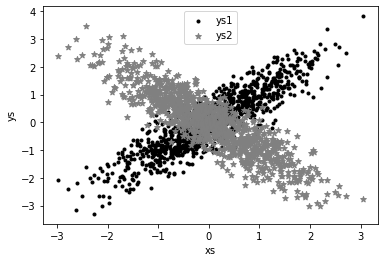

In [9]:
plt.scatter(xs,ys1,marker='.',color='black' , label = 'ys1')
plt.scatter(xs,ys2,marker='*',color='gray' , label='ys2')
plt.xlabel('xs')
plt.ylabel('ys')
plt.legend(loc=9)

Más dimensiones

In [10]:


def correlation_matrix(data):
    _, num_columns = shape(data)
    def matrix_entry(i,j):
        return correlation(get_column(data,1), get_column(data,j))
    return make_matrix(num_columns,num_columns,matrix_entry)



In [11]:
num_points = 100

def random_row():
    row = [None, None, None, None]
    row[0] = random_normal()
    row[1] = -5 * row[0] + random_normal()
    row[2] = row[0] + row[1] + 5 * random_normal()
    row[3] = 6 if row[2] > -2 else 0
    return row

data = [random_row()
    for _ in range(num_points)]

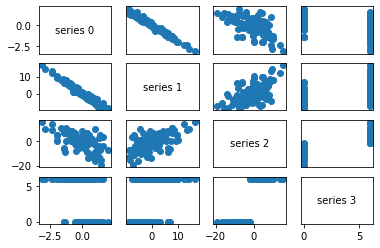

In [12]:
_, num_columns = shape(data)
fig, ax = plt.subplots(num_columns, num_columns)

for i in range(num_columns):
    for j in range(num_columns):

            # scatter column_j on the x-axis vs column_i on the y-axis
        if i != j: ax[i][j].scatter(get_column(data, j), get_column(data, i))

            # unless i == j, in which case show the series name
        else: ax[i][j].annotate("series " + str(i), (0.5, 0.5),
                                    xycoords='axes fraction',
                                    ha="center", va="center")

            # then hide axis labels except left and bottom charts
        if i < num_columns - 1: ax[i][j].xaxis.set_visible(False)
        if j > 0: ax[i][j].yaxis.set_visible(False)

    # fix the bottom right and top left axis labels, which are wrong because
    # their charts only have text in them
ax[-1][-1].set_xlim(ax[0][-1].get_xlim())
ax[0][0].set_ylim(ax[0][1].get_ylim())

plt.show()

### Manipulacion de datos

En esta seccion vamos a utilizar un par de herramientas para poder utilizar un diccionario

In [13]:
def picker(field_name):
    """returns a function that picks a field out of a dict"""
    return lambda row: row[field_name]

def pluck(field_name, rows):
    """turn a list of dicts into the list of field_name values"""
    return map(picker(field_name), rows)

def group_by(grouper, rows, value_transform=None):
    # key is output of grouper, value is list of rows
    grouped = defaultdict(list)
    for row in rows:
        grouped[grouper(row)].append(row)
    if value_transform is None:
        return grouped
    else:
        return { key : value_transform(rows)
                 for key, rows in grouped.items() }

def percent_price_change(yesterday, today):
    return today["closing_price"]  / yesterday["closing_price"] - 1

def day_over_day_changes(grouped_rows):
    # sort the rows by date
    ordered = sorted(grouped_rows, key=picker("date"))
    # zip with an offset to get pairs of consecutive days
    return [{ "symbol" : today["symbol"],
              "date" : today["date"],
              "change" : percent_price_change(yesterday, today) }
             for yesterday, today in zip(ordered, ordered[1:])]

In [14]:
from datetime import datetime
datum1 = [{
    'closing_price': 120.9,
    'date': datetime.strptime('11/12/2021', '%d/%m/%Y'),
    'symbol': 'AAPL'
},
{
    'closing_price': 150.9,
    'date': datetime.strptime('14/12/2021', '%d/%m/%Y'),
    'symbol': 'AAPL'
},
{
    'closing_price': 190.9,
    'date': datetime.strptime('16/12/2021', '%d/%m/%Y'),
    'symbol': 'AAPL'
}]



percent_price_change(datum1[0], datum1[1])


0.24813895781637707

In [15]:
day_over_day_changes(datum1)

[{'symbol': 'AAPL',
  'date': datetime.datetime(2021, 12, 14, 0, 0),
  'change': 0.24813895781637707},
 {'symbol': 'AAPL',
  'date': datetime.datetime(2021, 12, 16, 0, 0),
  'change': 0.2650762094102055}]

Rescalar mediante distancia Euclidiana

In [16]:
from math import dist as distance 
a_to_b = distance([63,150] , [67,160])
a_to_c = distance([43,120] , [60,155])
b_to_c = distance([70,150] , [30,135])
print(a_to_b)
print(a_to_c)
print(b_to_c)

10.77032961426901
38.91015291668744
42.720018726587654


In [17]:
def scale(data_matrix):
    num_rows, num_cols = shape(data_matrix)
    #regresa la media y desviacion estandar de cada columna
    means = [mean(get_column(data_matrix,j))
             for j in range(num_cols)]
    stdevs = [standard_deviation(get_column(data_matrix,j))
              for j in range(num_cols)]
    return means, stdevs

def rescale(data_matrix):
    """rescales the input data so that each column
    has mean 0 and standard deviation 1
    ignores columns with no deviation"""
    means, stdevs = scale(data_matrix)

    def rescaled(i, j):
        if stdevs[j] > 0:
            return (data_matrix[i][j] - means[j]) / stdevs[j]
        else:
            return data_matrix[i][j]

    num_rows, num_cols = shape(data_matrix)
    return make_matrix(num_rows, num_cols, rescaled)

In [18]:
scale([[1,4],[4,2]])

([2.5, 3.0], [2.1213203435596424, 1.4142135623730951])

In [19]:
rescale([[63,150],[67,160]])

[[-0.7071067811865475, -0.7071067811865475],
 [0.7071067811865475, 0.7071067811865475]]

Reduccion Dimensional

In [40]:
def scatter_plot(data):
  x = []
  y = []
  for i in data:
    x.append(i[0])
    y.append(i[1])

  plt.scatter(x,y)
  plt.show()

In [20]:
X = [
    [20.9666776351559,-13.1138080189357],
    [22.7719907680008,-19.8890894944696],
    [25.6687103160153,-11.9956004517219],
    [18.0019794950564,-18.1989191165133],
    [21.3967402102156,-10.8893126308196],
    [0.443696899177716,-19.7221132386308],
    [29.9198322142127,-14.0958668502427],
    [19.0805843080126,-13.7888747608312],
    [16.4685063521314,-11.2612927034291],
    [21.4597664701884,-12.4740034586705],
    [3.87655283720532,-17.575162461771],
    [34.5713920556787,-10.705185165378],
    [13.3732115747722,-16.7270274494424],
    [20.7281704141919,-8.81165591556553],
    [24.839851437942,-12.1240962157419],
    [20.3019544741252,-12.8725060780898],
    [21.9021426929599,-17.3225432396452],
    [23.2285885715486,-12.2676568419045],
    [28.5749111681851,-13.2616470619453],
    [29.2957424128701,-14.6299928678996],
    [15.2495527798625,-18.4649714274207],
    [26.5567257400476,-9.19794350561966],
    [30.1934232346361,-12.6272709845971],
    [36.8267446011057,-7.25409849336718],
    [32.157416823084,-10.4729534347553],
    [5.85964365291694,-22.6573731626132],
    [25.7426190674693,-14.8055803854566],
    [16.237602636139,-16.5920595763719],
    [14.7408608850568,-20.0537715298403],
    [6.85907008242544,-18.3965586884781],
    [26.5918329233128,-8.92664811750842],
    [-11.2216019958228,-27.0519081982856],
    [8.93593745011035,-20.8261235122575],
    [24.4481258671796,-18.0324012215159],
    [2.82048515404903,-22.4208457598703],
    [30.8803004755948,-11.455358009593],
    [15.4586738236098,-11.1242825084309],
    [28.5332537090494,-14.7898744423126],
    [40.4830293441052,-2.41946428697183],
    [15.7563759125684,-13.5771266003795],
    [19.3635588851727,-20.6224770470434],
    [13.4212840786467,-19.0238227375766],
    [7.77570680426702,-16.6385739839089],
    [21.4865983854408,-15.290799330002],
    [12.6392705930724,-23.6433305964301],
    [12.4746151388128,-17.9720169566614],
    [23.4572410437998,-14.602080545086],
    [13.6878189833565,-18.9687408182414],
    [15.4077465943441,-14.5352487124086],
    [20.3356581548895,-10.0883159703702],
    [20.7093833689359,-12.6939091236766],
    [11.1032293684441,-14.1383848928755],
    [17.5048321498308,-9.2338593361801],
    [16.3303688220188,-15.1054735529158],
    [26.6929062710726,-13.306030567991],
    [34.4985678099711,-9.86199941278607],
    [39.1374291499406,-10.5621430853401],
    [21.9088956482146,-9.95198845621849],
    [22.2367457578087,-17.2200123442707],
    [10.0032784145577,-19.3557700653426],
    [14.045833906665,-15.871937521131],
    [15.5640911917607,-18.3396956121887],
    [24.4771926581586,-14.8715313479137],
    [26.533415556629,-14.693883922494],
    [12.8722580202544,-21.2750596021509],
    [24.4768291376862,-15.9592080959207],
    [18.2230748567433,-14.6541444069985],
    [4.1902148367447,-20.6144032528762],
    [12.4332594022086,-16.6079789231489],
    [20.5483758651873,-18.8512560786321],
    [17.8180560451358,-12.5451990696752],
    [11.0071081078049,-20.3938092335862],
    [8.30560561422449,-22.9503944138682],
    [33.9857852657284,-4.8371294974382],
    [17.4376502239652,-14.5095976075022],
    [29.0379635148943,-14.8461553663227],
    [29.1344666599319,-7.70862921632672],
    [32.9730697624544,-15.5839178785654],
    [13.4211493998212,-20.150199857584],
    [11.380538260355,-12.8619410359766],
    [28.672631499186,-8.51866271785711],
    [16.4296061111902,-23.3326051279759],
    [25.7168371582585,-13.8899296143829],
    [13.3185154732595,-17.8959160024249],
    [3.60832478605376,-25.4023343597712],
    [39.5445949652652,-11.466377647931],
    [25.1693484426101,-12.2752652925707],
    [25.2884257196471,-7.06710309184533],
    [6.77665715793125,-22.3947299635571],
    [20.1844223778907,-16.0427471125407],
    [25.5506805272535,-9.33856532270204],
    [25.1495682602477,-7.17350567090738],
    [15.6978431006492,-17.5979197162642],
    [37.42780451491,-10.843637288504],
    [22.974620174842,-10.6171162611686],
    [34.6327117468934,-9.26182440487384],
    [34.7042513789061,-6.9630753351114],
    [15.6563953929008,-17.2196961218915],
    [25.2049825789225,-14.1592086208169]
]


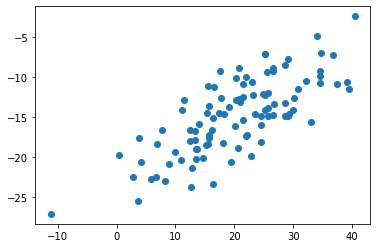

In [59]:
plt.scatter(*zip(*X))

In [21]:
def de_mean_matrix(A):
    nr,nc = shape(A)
    column_means, _ = scale(A)
    return make_matrix(nr,nc , lambda i , j: A[i][j] - column_means[j])

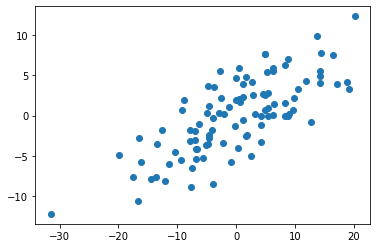

In [57]:
scatter_plot(de_mean_matrix(X))

In [41]:
de_mean_matrix(X)

[[0.6663708720254604, 1.6869418499129427],
 [2.4716840048703617, -5.088339625620959],
 [5.36840355288486, 2.805149417126742],
 [-2.29832726807404, -3.398169247664656],
 [1.096433447085161, 3.911437238029043],
 [-19.856609863952723, -4.921363369782158],
 [9.61952545108226, 0.7048830186059423],
 [-1.2197224551178394, 1.011875108017442],
 [-3.8318004109990405, 3.5394571654195417],
 [1.1594597070579589, 2.326746410178142],
 [-16.42375392592512, -2.774412592922358],
 [14.27108529254826, 4.095564703470643],
 [-6.927095188358241, -1.9262775805937569],
 [0.42786365106146107, 5.989093953283113],
 [4.539544674811559, 2.676653653106742],
 [0.001647710994760132, 1.9282437907588417],
 [1.601835929829459, -2.5217933707965567],
 [2.928281808418159, 2.533093026944142],
 [8.27460440505466, 1.5391028069033421],
 [8.995435649739662, 0.17075700094904178],
 [-5.05075398326794, -3.6642215585720574],
 [6.2564189769171605, 5.602806363228982],
 [9.89311647150566, 2.1734788842515425],
 [16.526437837975262, 7.54

In [23]:
def direction(w):
    mag = magnitude(w)
    return [w_i / mag for w_i in w]

def directional_variance_i(x_i,w):
    return dot(x_i, direction(w)) ** 2

def directional_variance(X,w):
    return sum(directional_variance_i(x_i,w) for x_i in X)
def directional_variance_gradient_i(x_i, w):

    projection_length = dot(x_i, direction(w))
    return [2 * projection_length * x_ij for x_ij in x_i]

def directional_variance_gradient(X, w):
    return vector_sum(directional_variance_gradient_i(x_i,w) for x_i in X)

def first_principal_component(X):
    guess = [1 for _ in X[0]]
    unscaled_maximizer = maximize_batch(
        partial(directional_variance, X),           # is now a function of w
        partial(directional_variance_gradient, X),  # is now a function of w
        guess)
    return direction(unscaled_maximizer)


In [24]:
first_principal_component(X)

[0.8483153298152323, -0.529491360836486]

In [53]:
a = zip(first_principal_component(X))


TypeError: 'float' object is not iterable

In [25]:
#stochasteic gradient descent
def first_principal_component_sgd(X):
    guess = [1 for _ in X[0]]
    unscaled_maximizer = maximize_stochastic(
        lambda x, _, w: directional_variance_i(x, w),
        lambda x, _, w: directional_variance_gradient_i(x, w),
        X, [None for _ in X], guess)
    return direction(unscaled_maximizer)

In [26]:
def project(v, w):

    coefficient = dot(v, w)
    return scalar_multiply(coefficient, w)

def remove_projection_from_vector(v, w):

    return vector_subtract(v, project(v, w))

def remove_projection(X, w):

    return [remove_projection_from_vector(x_i, w) for x_i in X]

In [27]:
def principal_component_analysis(X, num_components):
    components = []
    for _ in range(num_components):
        component = first_principal_component(X)
        components.append(component)
        X = remove_projection(X, component)

    return components

In [28]:
principal_component_analysis(X,2)

[[0.8483153298152323, -0.529491360836486],
 [0.5294915482155131, 0.8483152128591935]]

In [29]:
def transform_vector(v, components):
    return [dot(v, w) for w in components]
def transform(X, components):
    return [transform_vector(x_i, components) for x_i in X]

In [30]:
data = transform(X, principal_component_analysis(X,2))

In [31]:
type(data)

list

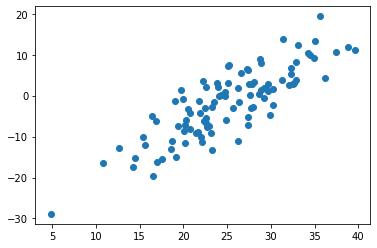

In [39]:
scatter_plot(data)

In [ ]:
if __name__ == "__main__":

    print("correlation(xs, ys1)", correlation(xs, ys1))
    print("correlation(xs, ys2)", correlation(xs, ys2))


correlation(xs, ys1) 0.8942816591816206
correlation(xs, ys2) -0.9030020118839109
